## Guide: using the genetic algorith for CRN exploration

In this notebook, we will show how to use a genetic algorithm as a metaheuristic to explore the space of chemical reaction networks (CRNs) using `SynthEvo`. 
We also show how to integrate the genetic algorithm with the proposed symbolic gradient descent optimization.

In this case we will consider specifically the case of ultrasensitivity detection. See
`synthetic_evolution_IFF.ipynb` and `synthetic_evolution_NFB.ipynb` for the Near-Perfect adaptation.

In [3]:
using SynthEvo

# load the CRN
C = make_FullyConnectedNonExplosive_CRN(3)
t0 = 10.
t1 = 20.
input = 1.

# prepare ODE problems for the state and sensitivities
base_problem_ode = make_base_problem_for_FCNE_CRN(C, C.ext_ode, t0, input) # this is faster to compute
base_problem_ext = make_base_problem_for_FCNE_CRN(C, C.ext_ode, t0, input)

nothing

Precompiling SynthEvo
  ✓ SynthEvo
  1 dependency successfully precompiled in 25 seconds. 374 already precompiled.


#### Ultrasensitivity

We will go step by step trough the setup of the problem, starting from the definition of the loss function.

The loss function is defined as the weighted sum of three terms:

* The ultrasensitivity loss enforces two different setpoints for values before and after a threshold.
* The steady state loss represents a soft-constraint for stability.
* The regularization loss enforces a sparse CRN.

In [4]:
loss1 = SynthEvo.ultrasensitivity_loss(C, 2, t1, 3, 4, input, 0.75, 0.25)
loss2 = SynthEvo.steady_state_loss(C, 2, t0, t1, t0-4, t1-4)
loss3 = SynthEvo.regularization_loss(C, 1)
# the weights of the loss (2nd argument) are hyperparameters
l = SynthEvo.weighted_loss([loss1, loss2, loss3], [10, 100, 0.01]) 

nothing

We now set up the gradient descent optimization, which can be called by the GA algorithm when needed.
Check the `symbolic_gradient_descent.ipynb` notebook for more details on these settings.

In [5]:
# these struct show all the possible hyperparameters for the gradient descent

# define the target perturbations at which to evaluate the loss
perturbation_list = vcat([2], [i+1 for i in 3:12], [0.1, 0.4, 0.6, 0.8])

gd_options = (
    n_iter = 100,
    verbose = false,
    use_random_perturbation = false,
    use_pruning_heuristic = false,
    clip_value = nothing,
    use_gradient_normalization = false,
    use_gradient_noise = false,
    fraction_gradient_noise = 0.01,
    alpha = 0.01,
    use_adam = false,
    ADAM_beta1 = 0.9,
    ADAM_beta2 = 0.9,
    use_adagrad = true
)

gd_perturbation_options = (
    t0 = t0,
    t1 = t1,
    loss_fun = l,
    input = input,
    perturbation_list = perturbation_list
)

nothing

And then for the genetic algorithm, following the conventions presented in our manuscript, we define the following parameters:

In [6]:
ga_options = (
    genetic_pool_size = 100,
    elite = 10,
    worst = 10,
    death_rate = 0.05,
    mutation_rate = 0.30,
    gradient_mutation_rate = 0.01,
    duplication_rate = 0.20,
    crossover_rate = 10.,
    max_generations = 10,
    p_cross = 0.1,
    dp = 0.01,
)

ga_perturbation_options = (
    use_random_perturbation = false,
    t0 = t0,
    t1 = t1,
    loss_fun = l,
    input = input,
    perturbation_list = perturbation_list
)

# function used by the GA to perform gradient guided mutations
mutate_with_GD = (p) -> SynthEvo.symbolic_gradient_descent(p, C, gd_options, gd_perturbation_options).parameters
# loss function used by the GA (efficiently setup to be computed in parallel) 
ga_loss = SynthEvo.prepare_GA_loss(C, base_problem_ode, ga_perturbation_options)


nothing

#### Near-Perfect Adaptation setup

We will omit some details as they are already coveres in the guide `symbolic_gradient_descent.ipynb`.

In [7]:
if run_mode == "near-perfect adaptation"
    # set up the loss function for near-perfect adaptation
    loss1 = SynthEvo.adaptation_loss(C, 2, 3, 10., 20.)
    loss2 = SynthEvo.sensitivity_loss(C, 2, 3, 0.25, 10., 10.5)
    loss3 = SynthEvo.steady_state_loss(C, 2, 10., 20., 6, 16.)
    loss4 = SynthEvo.regularization_loss(C, 1)
    l = SynthEvo.weighted_loss([loss1, loss2, loss3, loss4], [10,10,100,0.1])

    gd_options = (
        n_iter = 300,
        verbose = false,
        use_random_perturbation = false, # TODO maybe move to perturbation_options
        use_pruning_heuristic = false,
        clip_value = nothing,
        use_gradient_normalization = false,
        use_gradient_noise = false,
        fraction_gradient_noise = 0.01,
        alpha = 0.01,
        use_adam = false,
        ADAM_beta1 = 0.9,
        ADAM_beta2 = 0.9,
        use_adagrad = true
    )

    gd_perturbation_options = (
        t0 = t0,
        t1 = t1,
        loss_fun = l,
        input = input,
        perturbation_list = perturbation_list
    )

    ga_options = (
        genetic_pool_size = 100,
        elite = 10,
        worst = 10,
        death_rate = 0.05,
        mutation_rate = 0.30,
        gradient_mutation_rate = 0.01,
        duplication_rate = 0.20,
        crossover_rate = 10.,
        max_generations = 10,
        p_cross = 0.1,
        dp = 0.01,
    )

    ga_perturbation_options = (
        use_random_perturbation = false,
        t0 = t0,
        t1 = t1,
        loss_fun = l,
        input = input,
        perturbation_list = perturbation_list
    )

    mutate_with_GD = (p) -> SynthEvo.symbolic_gradient_descent(p, C, gd_options, gd_perturbation_options).parameters

    ga_loss = SynthEvo.prepare_GA_loss(C, base_problem_ode, ga_perturbation_options)
end

nothing

### running the genetic algorithm

This can be simply done by initializing a random state and then calling the `symbolic_evolve` function iteratively, as follows:

In [8]:
using ProgressBars

state = initialize_state(C.number_of_parameters, ga_options)

max_generations = ga_options.max_generations
iter = ProgressBar(1:max_generations)
for i in iter
    state = symbolic_evolve(ga_loss, state, mutate_with_GD, ga_options)
    set_postfix(iter, avg_loss=state.history.mean_loss[end], best_loss=state.history.best_loss[end])
end

nothing

0.0%┣                                              ┫ 0/10 [00:03<00:-29, -3s/it]
10.0%┣┫ 1/10 [01:53<Inf:Inf, InfGs/it, avg_loss: 4.503541853239098, best_loss: 0.8227857755498532]
20.0%┣┫ 2/10 [02:38<21:00, 158s/it, avg_loss: 3.86301406172078, best_loss: 0.8227857755498532]
30.0%┣┫ 3/10 [03:17<11:31, 99s/it, avg_loss: 3.0963021512849433, best_loss: 0.6020658427616564]
40.0%┣┫ 4/10 [03:59<07:58, 80s/it, avg_loss: 2.7326519091841828, best_loss: 0.6015002991615988]
50.0%┣┫ 5/10 [04:57<06:11, 74s/it, avg_loss: 2.193481730742619, best_loss: 0.5000985472433062]
60.0%┣┫ 6/10 [05:18<04:15, 64s/it, avg_loss: 1.6912932693864198, best_loss: 0.5000985472433062]
70.0%┣┫ 7/10 [06:11<03:05, 62s/it, avg_loss: 1.2108816229533959, best_loss: 0.4753422996764487]
80.0%┣┫ 8/10 [07:04<02:01, 61s/it, avg_loss: 1.0574317581290784, best_loss: 0.4742420652267904]
90.0%┣┫ 9/10 [07:24<00:55, 55s/it, avg_loss: 0.9178388043295292, best_loss: 0.4171032029838286]
100.0%┣┫ 10/10 [07:57<00:00, 53s/it, avg_loss: 0.80712

### Plotting the results

We can firstly check a summary of the training process:

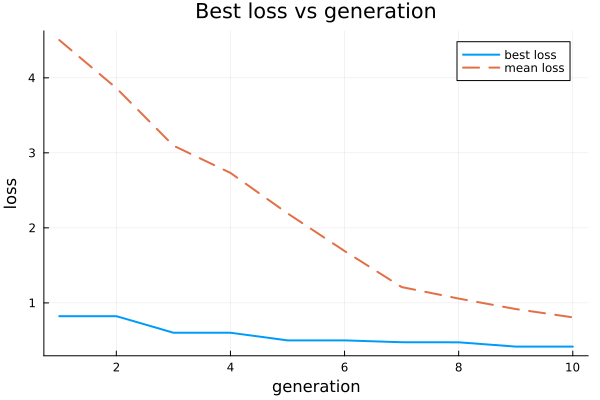

In [9]:
plot_history(state)

and we can plot the best CRN found by the genetic algorithm:

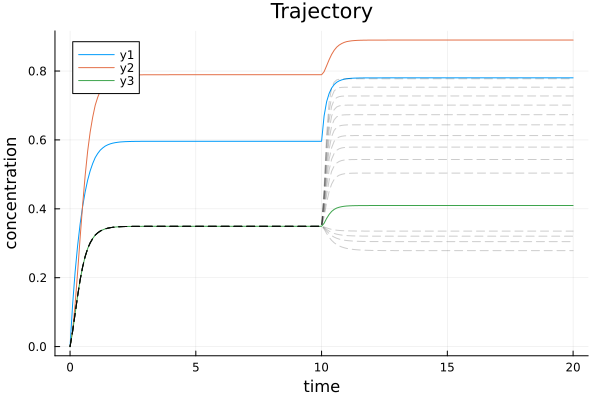

In [10]:
opt_index = argmin(state.fitness)

SynthEvo.quick_trajectory_plot(C, state.pool[opt_index], 1, gd_perturbation_options.perturbation_list, t0, t1, 3)

### Further refining a solution with GD

We can call the symbolic gradient descent optimization to further refine the optimal solution found by the genetic algorithm:

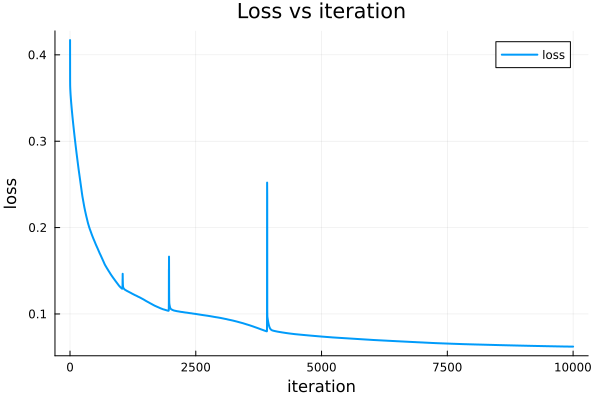

In [31]:
using Setfield

# we have to set the verbose option to true to see the progress of the optimization
gd_options_plot = @set gd_options.verbose = true
# additionaly we change some of the hyperparameters 
gd_options_plot = @set gd_options_plot.use_gradient_noise = true
gd_options_plot = @set gd_options_plot.fraction_gradient_noise = 0.05
gd_options_plot = @set gd_options_plot.n_iter = 10000
gd_options_plot = @set gd_options_plot.use_adagrad = true
gd_options_plot = @set gd_options_plot.alpha = 0.01

results = SynthEvo.symbolic_gradient_descent(state.pool[argmin(state.fitness)], C, gd_options_plot, gd_perturbation_options, nothing)

SynthEvo.symGD_plot_loss(results)

and we can check the final trajcectory

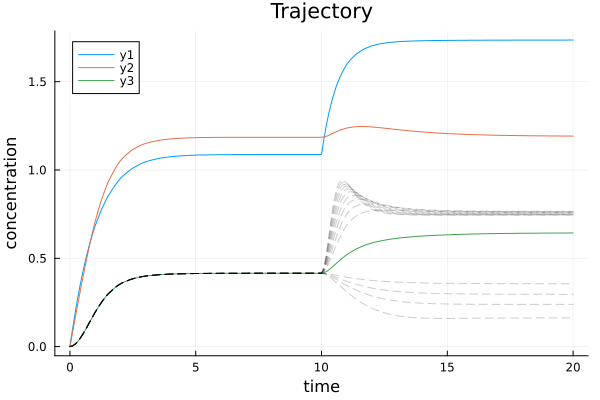

In [73]:
SynthEvo.quick_trajectory_plot(C, results.parameter_tape[argmin(results.loss_tape)], 1, gd_perturbation_options.perturbation_list, gd_perturbation_options.t0, gd_perturbation_options.t1, 3)

in the case of ultrasensitivity, we can also plot the the input-(steady state)output relationship:

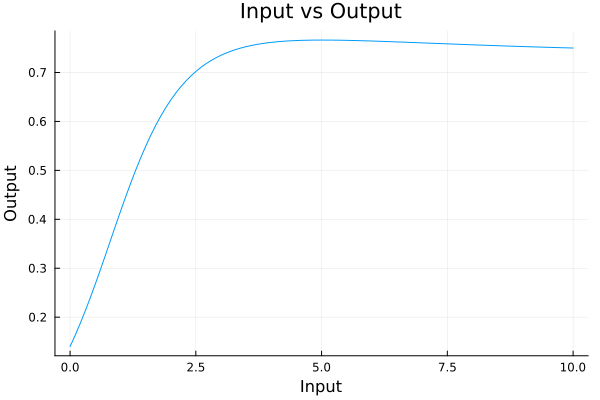

In [93]:
using Plots, ModelingToolkit
if run_mode == "ultrasensitivity"
    quick_IO_plot(C, results.parameter_tape[argmin(results.loss_tape)], 1., [0.1*i for i in 0:100], t0, t1, t1, 3)
end

In [85]:
f_CRN = sortAndFilterReactions(C, results.parameter_tape[argmin(results.loss_tape)], 0.03)
f_CRN.reaction_selection

14-element Vector{Tuple{Float64, Catalyst.Reaction{Any, Int64}}}:
 (0.9907627426573141, k[34], (x(t))[2] + (x(t))[3] --> ∅)
 (0.7718301714563258, k[1], ∅ --> (x(t))[2])
 (0.3080503302696178, k[27], (x(t))[1] --> ∅)
 (0.27802870963136334, k[16], (x(t))[1] --> 2*(x(t))[3])
 (0.26774857776495753, k[46], (x(t))[2] + (x(t))[3] --> (x(t))[1])
 (0.25166869105190987, k[47], (x(t))[2] + (x(t))[3] --> (x(t))[2])
 (0.22035202986982166, k[53], 2*(x(t))[1] --> 2*(x(t))[2])
 (0.16381980717656403, k[31], (x(t))[1] + (x(t))[2] --> ∅)
 (0.1483071550892649, k[66], 2*(x(t))[2] --> 2*(x(t))[1])
 (0.09475520967866505, k[58], (x(t))[1] + (x(t))[2] --> 2*(x(t))[2])
 (0.08391144790685852, k[7], (x(t))[1] --> (x(t))[3])
 (0.0479488779089146, k[39], (x(t))[1] + (x(t))[2] --> (x(t))[2])
 (0.03206907661309547, k[44], 2*(x(t))[2] --> (x(t))[1])
 (0.031193743203556955, k[68], 2*(x(t))[2] --> (x(t))[1] + (x(t))[3])

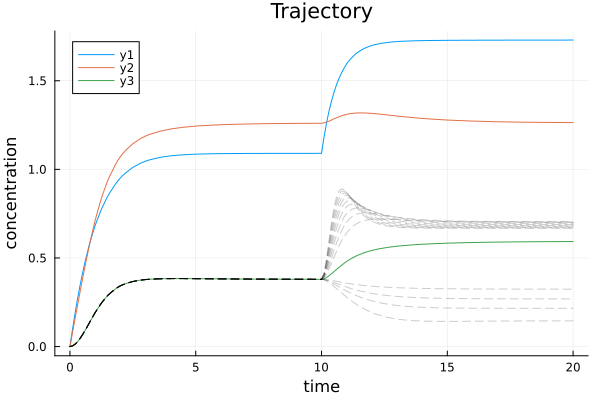

In [86]:
SynthEvo.quick_trajectory_plot(C, f_CRN.filtered_parameters, 1, gd_perturbation_options.perturbation_list, gd_perturbation_options.t0, gd_perturbation_options.t1, 3)

### Save and reload the model ald optimization state

We provide simple utilities to save and reload the model, they can be used as follows:

In [ ]:
# saving

SynthEvo.save_ga_state("test_run.jld2",
    C, state,
    gd_options, ga_options,
    gd_perturbation_options, ga_perturbation_options
)

nothing

In [ ]:
# loading

test_load = SynthEvo.load_object("test_run.jld2") 

C = test_load["C"]
state = test_load["state"]
gd_options = test_load["gd_options"]
ga_options = test_load["ga_options"]
gd_perturbation_options = test_load["gd_perturbation_options"]
ga_perturbation_options = test_load["ga_perturbation_options"]

base_problem_ode = make_base_problem_for_FCNE_CRN(C, C.ext_ode, gd_perturbation_options.t0, gd_perturbation_options.input) # this is faster to compute
base_problem_ext = make_base_problem_for_FCNE_CRN(C, C.ext_ode, gd_perturbation_options.t0, gd_perturbation_options.input)

mutate_with_GD = (p) -> SynthEvo.symbolic_gradient_descent(p, C, gd_options, gd_perturbation_options).parameters
ga_loss = SynthEvo.prepare_GA_loss(C, base_problem_ode, ga_perturbation_options)

nothing